# Aprendizagem de Máquina I

## Hugo Tremonte de Carvalho

#### hugo@dme.ufrj.br

NOMES:
* Leon Martins Uchoa Barboza

Este _notebook_ é correspondente ao nosso primeiro projeto, passado no dia 22/08/2024 e para entrega no dia 19/09/2024. Ele consiste em questões teóricas e questões práticas. A entrega da atividade deve ser feita através do Google Classroom, fazendo um _upload_ deste _notebook_, devidamente atualizado com as suas resoluções e implementações. Recomendo fortemente que façam o trabalho no Google Colab, pois assim temos certa garantia de estarmos rodando tudo no mesmo ambiente e que eu conseguir executar o código de vocês sem dificuldades.

A resolução das questões teóricas pode ser feita de duas formas:
* Escrita em $\LaTeX$ aqui no próprio Google Colab
* Escrita à mão, escaneada de modo legível, e feito o upload no Google Classroom.

A primeira alternativa é mais recomendada, por deixar o trabalho mais organizado, e cá entre nós, estar tudo em um documento só me facilita a correção! :-) mas para quem não tem fluência com $\LaTeX$ ou prefere fazer à mão, a segunda alternativa está aí. Obviamente que não haverá punição nenhuma meramente por conta da escolha de sua preferência.

O projeto poderá ser feito **até** em dupla: quem quer fazer sozinho/a faz, mas quem quiser fazer em dupla também tem esse direito.

## Parte prática

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize,
poly)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (mean_squared_error as MSE, r2_score)
from itertools import combinations
from joblib import Parallel, delayed

### 1) Regressão linear múltipla

Resolva o exercício 9 da Sec. 3.7 do Cap. 3 de [ITSL].

#### A) 
Há uma aparente correlação entre diversas covariáveis do conjunto de dados. Dentre elas, destacam-se:   
-  Weight e Horsepower
-  Horsepower e Displacement
-  Weight e Displacement

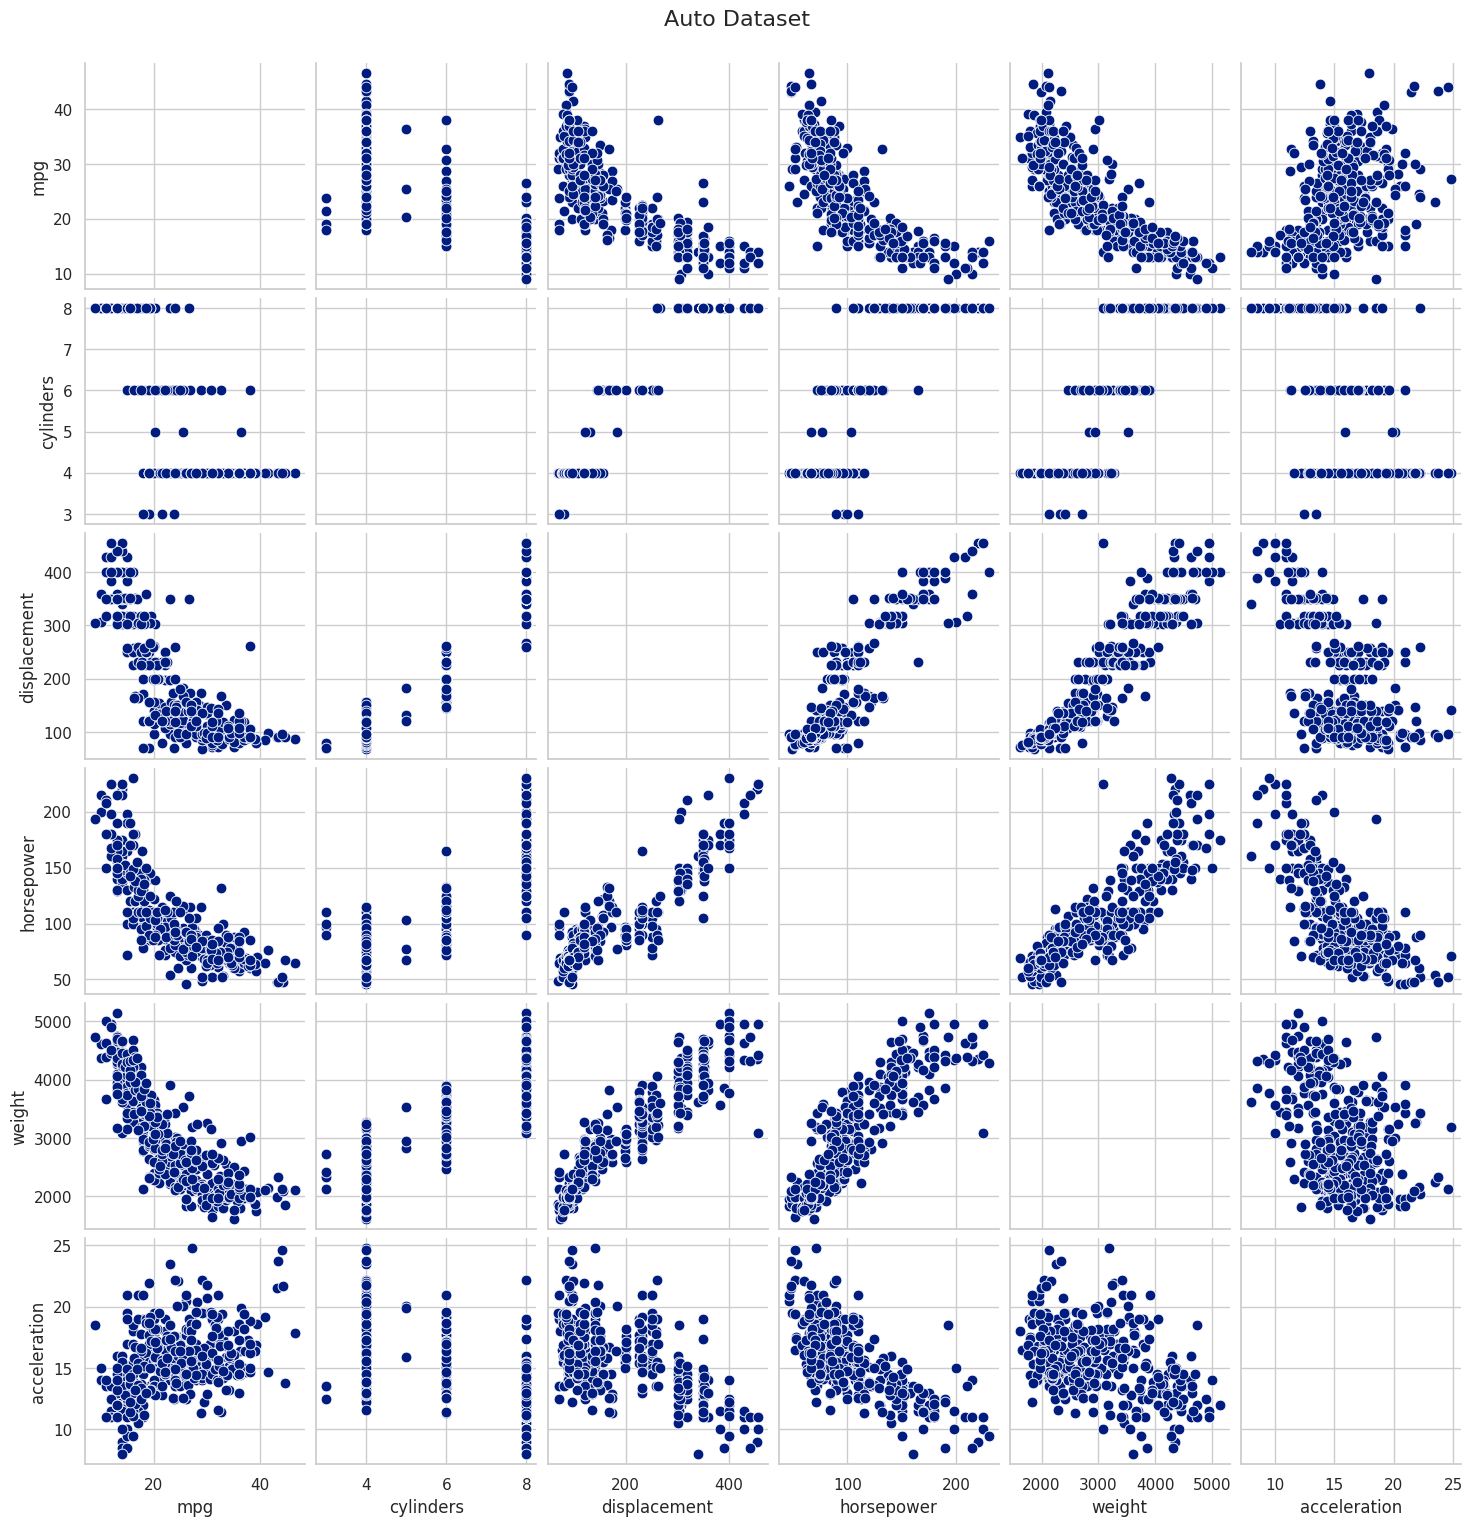

In [6]:
df: pd.DataFrame = load_data("Auto")

sns.set_theme(style="whitegrid", palette="dark")
pair_plot: sns.axisgrid.PairGrid = sns.pairplot(
    df,    
    vars=["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration"],
    markers=["o", "s", "D"],
    diag_kind="scatter",          
    height=2.5,               
    plot_kws={"s": 60}  
)


pair_plot.fig.suptitle("Auto Dataset", y=1.02, fontsize=16)

plt.show()

#### B)

In [7]:
df.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


#### C)

In [25]:
y: np.ndarray = df["mpg"].to_numpy()

X: np.ndarray = df.drop(["mpg"], axis=1)

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Sat, 21 Sep 2024   Prob (F-statistic):          2.04e-139
Time:                        10:11:06   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707      0.000     -26.350      -8.087
cylinders       -0.4934      0.323     -1.526      0.128      -1.129       0.142
displacement     0.0199      0.008      2.647      0.008       0.005       0.035
horsepower      -0.0170      0.014     -1.230      0.220      -0.044       0.010
weight          -0.0065      0.001     -9.929      0.000      -0.008      -0.005
acceleration     0.0806      0.099      0.815      0.415      -0.114       0.275
year             0.7508      0.051     14.729      0.000       0.651       0.851
origin           1.4261      0.278      5.127      0.000       0.879       1.973
==============================================================================
Omnibus:                       31.906   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.100
Skew:                           0.529   Prob(JB):                     2.95e-12
Kurtosis:                       4.460   Cond. No.                     8.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### i)

Sim. Entretanto, há possivelmente um problema de colinearidade observado anteriormente na análise. 

In [10]:
modelFormulaAPI = smf.ols("mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin", data=df)

resultsFormula = modelFormulaAPI.fit()

anova_lm(resultsFormula)

,df,sum_sq,mean_sq,F,PR(>F)
cylinders,1.0,14403.083079,14403.083079,1300.683788,2.319511e-125
displacement,1.0,1073.344025,1073.344025,96.929329,1.530906e-20
horsepower,1.0,403.408069,403.408069,36.430140,3.731128e-09
weight,1.0,975.724953,975.724953,88.113748,5.544461e-19
acceleration,1.0,0.966071,0.966071,0.087242,7.678728e-01
year,1.0,2419.120249,2419.120249,218.460900,1.875281e-39
origin,1.0,291.134494,291.134494,26.291171,4.665681e-07
Residual,384.0,4252.212530,11.073470,NaN,NaN


##### ii)

Displacement, Weight, Year, Origin aparentam ser bons preditores pelos baixos p-valores

##### iii)

O coeficiente para o preditor years indica que a eficiência dos motores cresce conforme o ano de produção.

#### D)

Os resíduos não parecem estar bem distribuidos ao redor do 0, mostrando uma possível falha da hipótese de média 0 dos erros ou da variância constante dos erros.


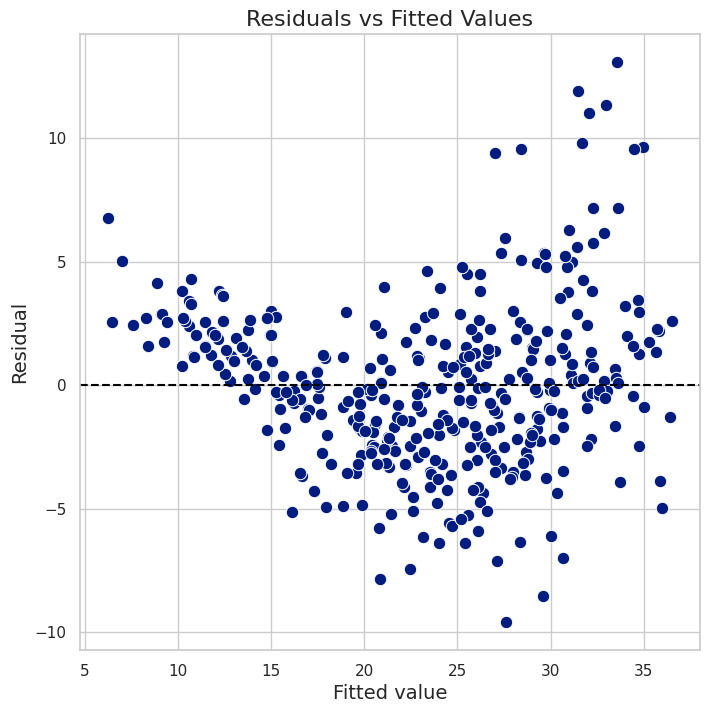

In [11]:
plt.figure(figsize=(8, 8))
sns.set_theme(style="whitegrid", palette="dark")

sns.scatterplot(
    x=results.fittedvalues, 
    y=results.resid, 
    s=80,  
)

plt.xlabel("Fitted value", fontsize=14)
plt.ylabel("Residual", fontsize=14)

plt.axhline(0, color="black", linestyle="--")

plt.title("Residuals vs Fitted Values", fontsize=16)

plt.show()

A parte inicial do qqplot não está bem alinhada com a reta de referência, mostrando uma possível falha na hipótese de normalidade dos erros


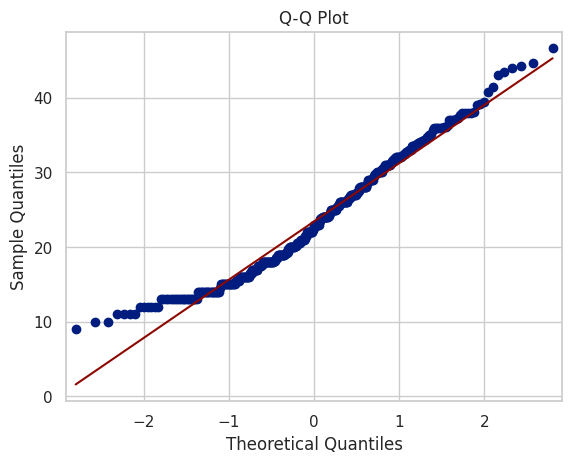

In [12]:
sm.qqplot(y, line='s')
plt.title("Q-Q Plot")
plt.show()

Há apenas uma observação considerada como ponto de alavanca: buick state wagon (sw).

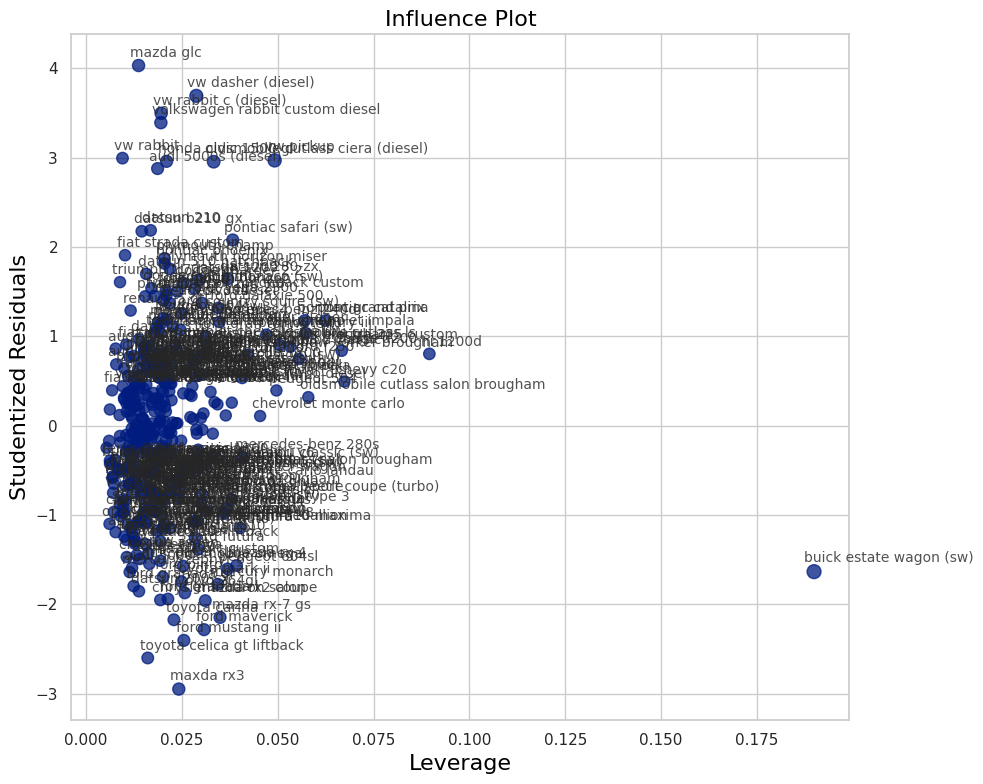

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))  
sm.graphics.influence_plot(results, criterion="cooks", ax=ax, alpha=0.7, size=10)

for text in ax.texts:
    text.set_fontsize(10)  
    text.set_alpha(0.8)    

plt.tight_layout()  
plt.show()


#### E)

In [24]:
features = ["cylinders", "displacement", "horsepower", "weight", 
            "acceleration", "year", "origin"]

interactions = [("horsepower", "weight"), 
                ("horsepower", "acceleration"), 
                ("displacement", "weight")]

X = MS(features + interactions).fit_transform(df)
y = df["mpg"]

model_inter = sm.OLS(y, X)
results_inter = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     247.9
Date:                Sat, 21 Sep 2024   Prob (F-statistic):          5.53e-160
Time:                        10:10:46   Log-Likelihood:                -966.10
No. Observations:                 392   AIC:                             1954.
Df Residuals:                     381   BIC:                             1998.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 -10.0595      5.623     -1.789      0.074     -21.115       0.996
cylinders                   0.2760      0.296      0.933      0.352      -0.306       0.858
displacement               -0.0336      0.020     -1.687      0.092      -0.073       0.006
horsepower                 -0.0637      0.058     -1.107      0.269      -0.177       0.049
weight                     -0.0092      0.001    -10.149      0.000      -0.011      -0.007
acceleration                0.4527      0.169      2.672      0.008       0.120       0.786
year                        0.7759      0.044     17.456      0.000       0.688       0.863
origin                      0.5935      0.264      2.251      0.025       0.075       1.112
horsepower:weight        2.991e-05    1.3e-05      2.294      0.022    4.27e-06    5.56e-05
horsepower:acceleration    -0.0063      0.002     -3.548      0.000      -0.010      -0.003
displacement:weight       8.12e-06   5.43e-06      1.497      0.135   -2.55e-06    1.88e-05
==============================================================================
Omnibus:                       32.907   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.762
Skew:                           0.491   Prob(JB):                     1.43e-14
Kurtosis:                       4.715   Cond. No.                     3.60e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.6e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 As novas interações fizeram $R^2$ subir de 0.821 para 0.867.

In [26]:
anova_lm(results, results_inter)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,384.0,4252.212530,0.0,NaN,NaN,NaN
1,381.0,3173.066256,3.0,1079.146274,43.192157,4.779816e-24


O p-valor do teste F indica a superioridade do modelo com interações em relação ao modelo original.

#### F)

É possível ver pela análise exploratória de dados que displacement, horsepower e weight não tem uma relação muito linear com a variável mpg, mas aplicando o log em cada uma delas a relação é mais linear (mesmo que tenhamos perdido interpretabilidade)

De fato aplicando o log mais uma vez a relação se torna (aparentemente) ainda mais linear

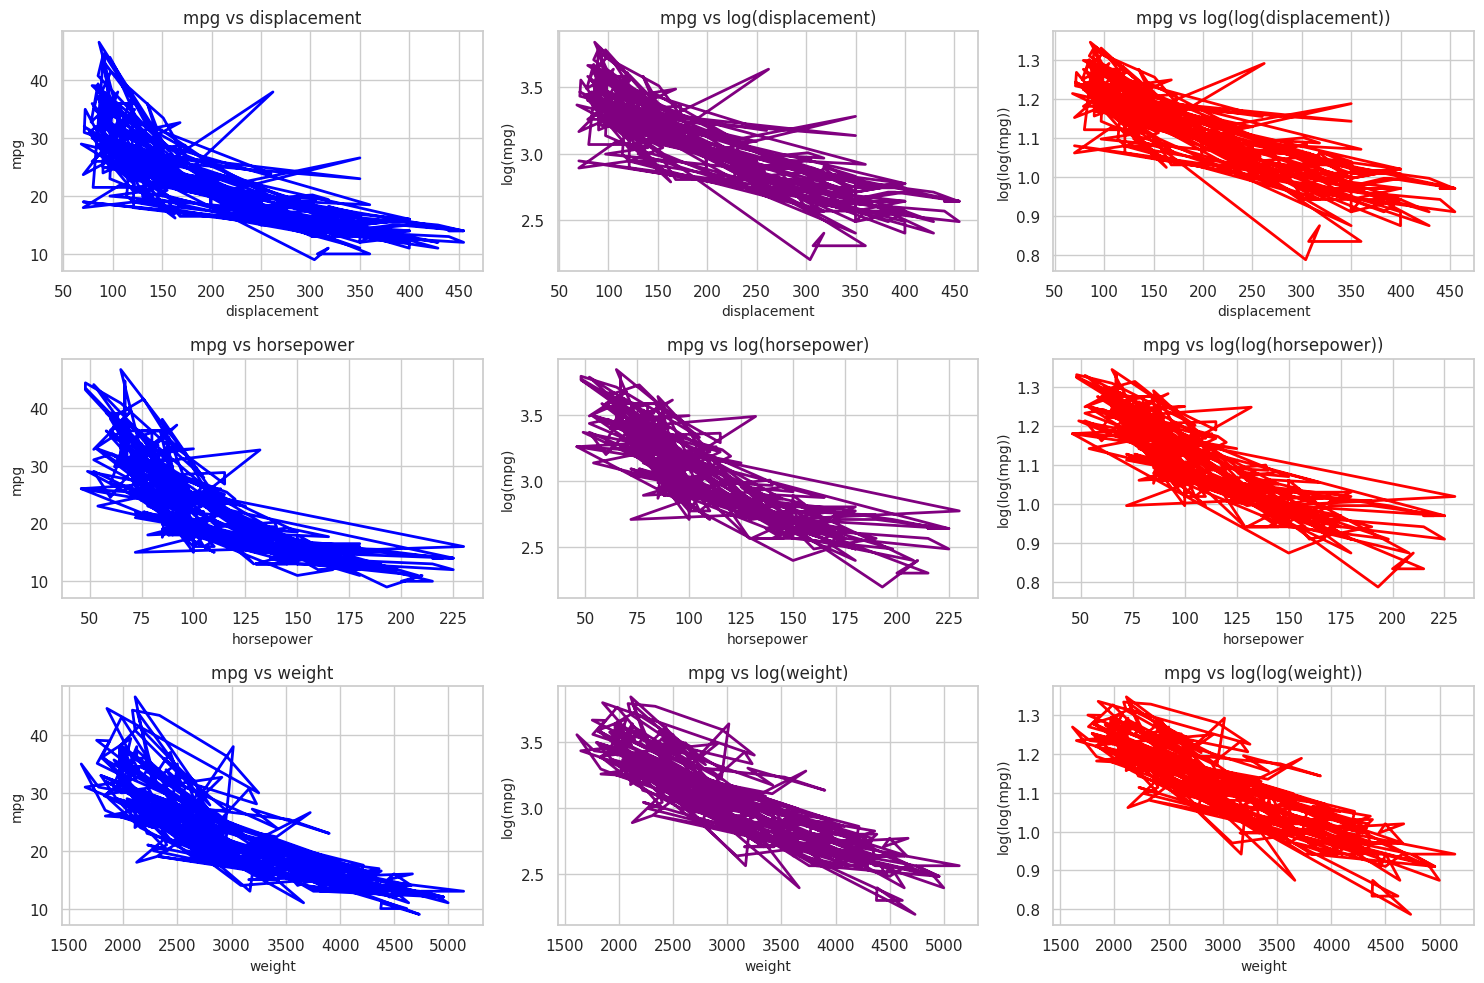

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  

ax11, ax12, ax13 = axes[0]
ax21, ax22, ax23 = axes[1]
ax31, ax32, ax33 = axes[2]

ax11.plot(df["displacement"], df["mpg"], color="blue", lw=2)
ax11.set_title("mpg vs displacement", fontsize=12)
ax11.set_xlabel("displacement", fontsize=10)
ax11.set_ylabel("mpg", fontsize=10)

ax12.plot(df["displacement"], np.log(df["mpg"]), color="purple", lw=2)
ax12.set_title("mpg vs log(displacement)", fontsize=12)
ax12.set_xlabel("displacement", fontsize=10)
ax12.set_ylabel("log(mpg)", fontsize=10)

ax13.plot(df["displacement"], np.log(np.log(df["mpg"])), color="red", lw=2)
ax13.set_title("mpg vs log(log(displacement))", fontsize=12)
ax13.set_xlabel("displacement", fontsize=10)
ax13.set_ylabel("log(log(mpg))", fontsize=10)

ax21.plot(df["horsepower"], df["mpg"], color="blue", lw=2)
ax21.set_title("mpg vs horsepower", fontsize=12)
ax21.set_xlabel("horsepower", fontsize=10)
ax21.set_ylabel("mpg", fontsize=10)

ax22.plot(df["horsepower"], np.log(df["mpg"]), color="purple", lw=2)
ax22.set_title("mpg vs log(horsepower)", fontsize=12)
ax22.set_xlabel("horsepower", fontsize=10)
ax22.set_ylabel("log(mpg)", fontsize=10)

ax23.plot(df["horsepower"], np.log(np.log(df["mpg"])), color="red", lw=2)
ax23.set_title("mpg vs log(log(horsepower))", fontsize=12)
ax23.set_xlabel("horsepower", fontsize=10)
ax23.set_ylabel("log(log(mpg))", fontsize=10)

ax31.plot(df["weight"], df["mpg"], color="blue", lw=2)
ax31.set_title("mpg vs weight", fontsize=12)
ax31.set_xlabel("weight", fontsize=10)
ax31.set_ylabel("mpg", fontsize=10)

ax32.plot(df["weight"], np.log(df["mpg"]), color="purple", lw=2)
ax32.set_title("mpg vs log(weight)", fontsize=12)
ax32.set_xlabel("weight", fontsize=10)
ax32.set_ylabel("log(mpg)", fontsize=10)

ax33.plot(df["weight"], np.log(np.log(df["mpg"])), color="red", lw=2)
ax33.set_title("mpg vs log(log(weight))", fontsize=12)
ax33.set_xlabel("weight", fontsize=10)
ax33.set_ylabel("log(log(mpg))", fontsize=10)

plt.tight_layout()

plt.show()

In [31]:
X = MS(features).fit_transform(df)

X["displacement"] = np.log(X["displacement"])
X["horsepower"] = np.log(X["horsepower"])
X["weight"] = np.log(X["weight"])

y = df["mpg"]
model_log = sm.OLS(y, X)
results_log = model_log.fit()
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     305.6
Date:                Sat, 21 Sep 2024   Prob (F-statistic):          1.06e-152
Time:                        10:20:47   Log-Likelihood:                -992.17
No. Observations:                 392   AIC:                             2000.
Df Residuals:                     384   BIC:                             2032.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept      110.5570     10.147     10.896      0.000      90.607     130.507
cylinders        0.4333      0.285      1.518      0.130      -0.128       0.995
displacement    -1.3577      1.421     -0.956      0.340      -4.151       1.436
horsepower      -5.7484      1.563     -3.678      0.000      -8.822      -2.675
weight         -13.7989      2.192     -6.296      0.000     -18.108      -9.490
acceleration    -0.1954      0.103     -1.906      0.057      -0.397       0.006
year             0.7296      0.047     15.516      0.000       0.637       0.822
origin           0.8160      0.280      2.919      0.004       0.266       1.366
==============================================================================
Omnibus:                       43.287   Durbin-Watson:                   1.383
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.921
Skew:                           0.624   Prob(JB):                     2.20e-19
Kurtosis:                       4.925   Cond. No.                     5.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

O modelo com as transformações aplicadas é superior ao modelo original. Porém, o modelo com interações ainda performa melhor.

### 2) Seleção de variáveis

Resolva o exercício 10 da Sec. 6.6 do Cap. 6 de [ITSL]. Explique o que é o *best subset selection*, invocado no item c).

Obs.: Esse exercício é parecido com o que fizemos em uma aula prática, porém ele tem algumas perguntinhas adicionais. Para fazê-lo, você precisará ver o que é o *best subset selection*, que é apresentado na pág. 231. Claro, use o código que desenvolvemos em sala de aula como ponto de partida para a geração dos dados sintéticos.

#### A)

In [34]:
np.random.seed(42)

n, p = 1000, 20

X: np.ndarray = np.random.randn(n, p)

beta = np.random.randn(p)
beta[10:] = 0  

epsilon = np.random.randn(n)

y = X @ beta + epsilon

#### B)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

#### C)

In [60]:
comb = [list(combinations(np.arange(p), l)) for l in range(1, p + 1)]
flattened_comb = [index for sublist in comb for index in sublist]  

best_models_train = {l: {"mse_train": float("inf"), "indices": list[None] } for l in range(1, p + 1)}
best_models_test = {l: {"mse_test": float("inf"), "indices": list[None] } for l in range(1, p + 1)}

def fit_model(indices):
    model = LinearRegression()
    model.fit(X_train[:, indices], y_train)
    
    pred_train = model.predict(X_train[:, indices])
    pred_test =  model.predict(X_test[:, indices])
    mse_train = MSE(y_train, pred_train)
    mse_test = MSE(y_test, pred_test)
    return mse_train, mse_test, len(indices), indices

In [61]:
results = Parallel(n_jobs=-1)(delayed(fit_model)(indices) for indices in flattened_comb)

In [65]:
for mse_train, mse_test, size, indices in results:
    if mse_train < best_models_train[size]["mse_train"]:
        best_models_train[size] = {"mse_train": mse_train, "indices": indices}
    
    if mse_test < best_models_test[size]["mse_test"]:
        best_models_test[size] = {"mse_test": mse_test, "indices": indices}

#### D)

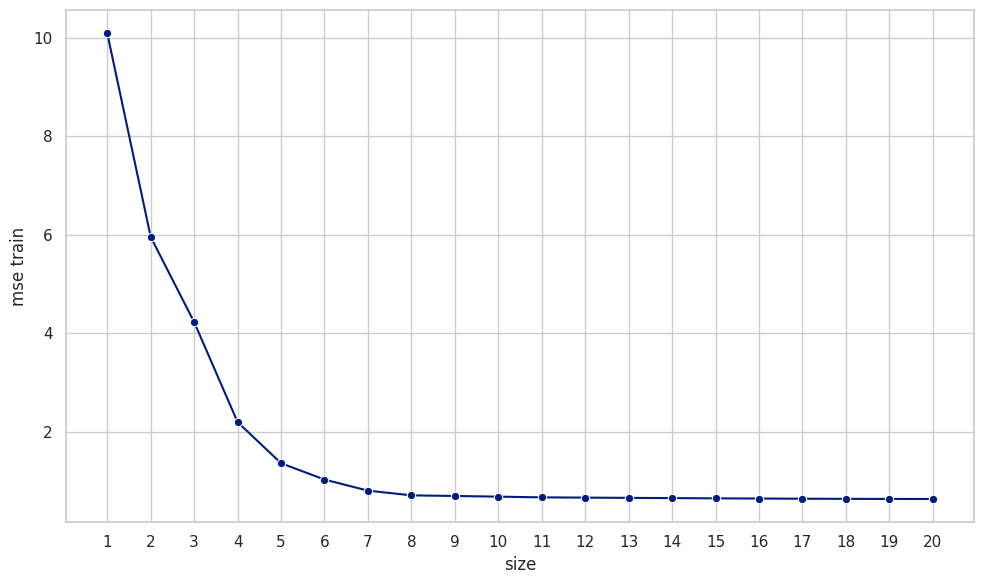

In [73]:
train_sizes = list(best_models_train.keys())
train_mse = [best_models_train[l]["mse_train"] for l in train_sizes]

train_data = pd.DataFrame({
    "size": train_sizes,
    "mse train": train_mse
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=train_data, x="size", y="mse train", marker="o")
plt.xticks(train_sizes)
plt.tight_layout()
plt.show()

#### E)

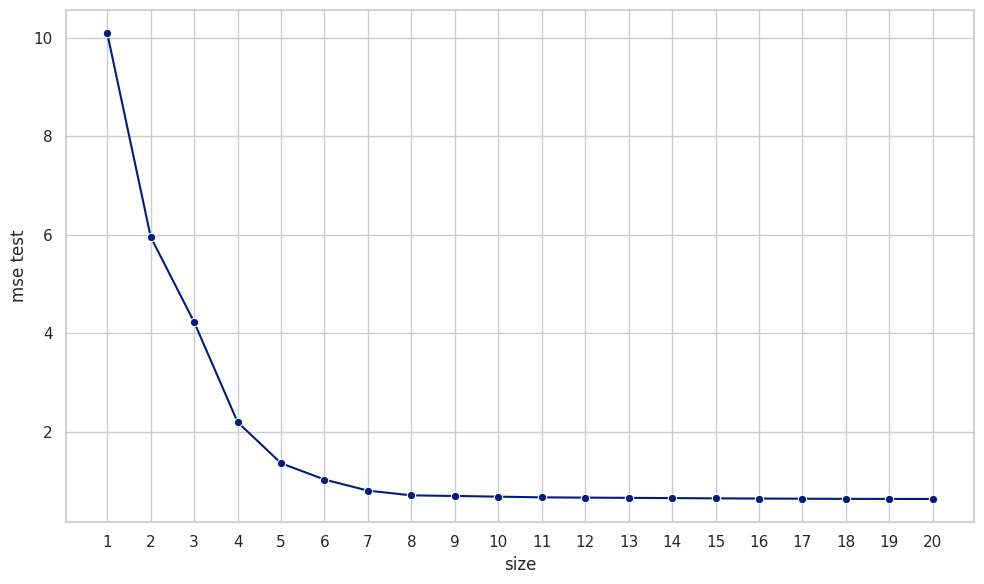

In [72]:
test_sizes = list(best_models_test.keys())
test_mse = [best_models_test[l]["mse_test"] for l in test_sizes]

test_data = pd.DataFrame({
    "size": train_sizes,
    "mse test": train_mse
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=test_data, x="size", y="mse test", marker="o")
plt.xticks(test_sizes)
plt.tight_layout()
plt.show()

#### E)

In [75]:
key = min(best_models_test, key=lambda l: best_models_test[l]["mse_test"])
best_models_test[key]["indices"]

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17)

#### F)

In [78]:
for i, value in enumerate(beta):
    print(f"beta_{i} = {value}")

beta_0 = 0.3482862476668184
beta_1 = 0.28332359253566647
beta_2 = -0.9365198458054912
beta_3 = 0.5795842217637382
beta_4 = -1.490082675576618
beta_5 = -0.6541843257603286
beta_6 = -1.9990878128978078
beta_7 = 1.5586265169628146
beta_8 = -0.23154949394529548
beta_9 = 2.1668840348163116
beta_10 = 0.0
beta_11 = 0.0
beta_12 = 0.0
beta_13 = 0.0
beta_14 = 0.0
beta_15 = 0.0
beta_16 = 0.0
beta_17 = 0.0
beta_18 = 0.0
beta_19 = 0.0


In [89]:
model = LinearRegression()
best_indices = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17)
model.fit(X_train[:, best_indices], y_train)
beta_best = model.coef_
for i, value in enumerate(beta_best):
    print(f"beta_{best_indices[i]} = {value}")

beta_0 = 0.0783481937269029
beta_1 = 0.5065960698361636
beta_2 = -0.880636083417266
beta_3 = 0.3709598988983594
beta_4 = -1.5439400258159297
beta_5 = -0.6381994293565048
beta_6 = -1.9823687249981858
beta_7 = 1.5224139689093366
beta_8 = -0.13910148444563453
beta_9 = 2.0862293336394178
beta_12 = -0.08005653144562952
beta_15 = 0.08142001371207308
beta_16 = 0.03904480774582458
beta_17 = -0.047894473413746926


#### G)

In [88]:
coefficients = []
for i in best_models_test:
    model = LinearRegression()
    indices = best_models_test[i]["indices"]
    model.fit(X_train[:, indices], y_train)
    coefficients.append(model.coef_)

In [99]:
results = []
for i in best_models_test:
    indices = best_models_test[i]["indices"]
    beta_l = np.array(beta)[list(indices)]
    expression = np.sqrt(np.sum((beta_l - coefficients[i - 1])**2))
    results.append(expression)

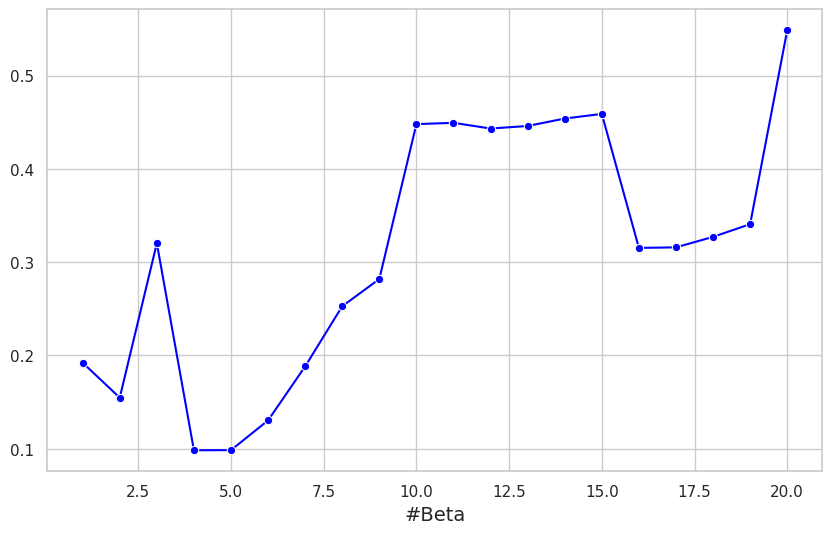

In [105]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(1, 21), y=results, marker="o", color="blue")
plt.xlabel("#Beta", fontsize=14)
plt.show()